In [16]:
using Pkg;
using DynamicalSystems
using PyPlot
using DifferentialEquations
using Random 
using Statistics
using NPZ
using JLD
using CSV
using DataFrames
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 14;

In [2]:
function Josephson_neuron!(dy,y,params,t)
  i_in,L_p, L_s, G, l, h, i_bi = params
  ph_p, om_p, ph_c, om_c = y
  
  dy[1] = om_p 
  dy[2] = -G * om_p - sin(ph_p) - l *  (ph_c + ph_p) + L_s * i_in   + i_bi * (1 - L_p)
  dy[3] = om_c
  dy[4] = -G * om_c - sin(ph_c) - l/h *(ph_c + ph_p) + L_s * i_in/h - i_bi *  L_p/h
end

function Josephson_neuron_rotated!(dy,y,params,t)
  i_in,L_p, L_s, G, l, h, i_bi = params
  theta_1, om_1, theta_2, om_2 = y
  
  dy[1] = om_1 
  dy[2] =-G*om_1 - 2*sin(theta_1/2)*cos(theta_2/2) -l*theta_1*(1+1/h) + L_s*i_in*(1+1/h) +i_bi*(1-L_p-L_p/h)
  dy[3] = om_2
  dy[4] =-G*om_2 - 2*sin(theta_2/2)*cos(theta_1/2) -l*theta_1*(1-1/h) + L_s*i_in*(1-1/h) +i_bi*(1-L_p+L_p/h)
  
end

function Josephson_neuron_jacobian!(J, y, params, t)
  i_in,L_p, L_s, G, l, h, i_bi = params
  ph_p, om_p, ph_c, om_c = y
  
  J[1,:] = [0,1,0,0]
  J[2,:] = [-cos(ph_p)-l,-G,-l,0]
  J[3,:] = [0,0,0,1]
  J[4,:] = [-l,0,-cos(ph_c)-l,-G]
end

rng = MersenneTwister(42)

function Josephson_neuron_noise!(dy,y,params,t)
  i_in,L_p, L_s, G, l, h, i_bi, sigma = params
  ph_p, om_p, ph_c, om_c = y
  i_in = i_in+sigma*randn(rng,Float64)
    
  dy[1] = om_p 
  dy[2] = -G * om_p - sin(ph_p) - l *  (ph_c + ph_p) + L_s * i_in   + i_bi * (1 - L_p)
  dy[3] = om_c
  dy[4] = -G * om_c - sin(ph_c) - l/h *(ph_c + ph_p) + L_s * i_in/h - i_bi *  L_p/h
end

## Return frequency and standart deviation 
## @param signal
## @param time
## @param tolerance. 
## if tolerance not initialised it is given by (2max_signal-signal[ind_max_signal-1]-signal[ind_max_signal+1])/2
##
function find_frequency_error(signal::Vector,time::Vector;tolerance=0)
    max_signal,ind_max_signal = findmax(signal[2:end-1])
    ind_max_signal += 1 
    tolerance==0 ? tolerance = (2max_signal-signal[ind_max_signal+1]-signal[ind_max_signal-1])/4 : nothing
    indxs_maximum =[]
    i=2
    while(i<length(signal)-1)
        if(abs(signal[i]-max_signal)<tolerance&&signal[i-1]<signal[i]>signal[i+1])
            push!(indxs_maximum,time[i])
        end
        i+=1
    end

    if(length(indxs_maximum)<3)
        return [0,0]
    else
        allT=diff(indxs_maximum)
    end
    diffTmean = mean(allT)
  return [1/diffTmean,std(allT)/diffTmean^2]
end

find_frequency_error (generic function with 1 method)

In [3]:
function edge_arcsin_func(i_bi::Number)
    if(i_bi>=2 || i_bi<=-2)
        return []
    elseif(i_bi>=0)
        return [asin(i_bi-1),pi-asin(i_bi-1)]
    elseif(i_bi<0)
        return [-pi-asin(i_bi+1),asin(i_bi+1)]
    end
end
    
function func_where0_fp(x,params)
  i_in ,L_p, L_s, G, l, h, i_b = params
  return @. sin(x)-sin(-sin(x)/l-x+(L_s*i_in+(1-L_p)*i_b)/l)-i_b
end

function phic_in_fp(phip,params)
  i_in ,L_p, L_s, G, l, h, i_b = params
  return @. -sin(phip)/l-phip+(L_s*i_in+(1-L_p)*i_b)/l
end


phic_in_fp (generic function with 1 method)

In [4]:
function find_phip_fp(params,tol = 0.01)
    x = range(edge_arcsin_func(params[7])...,step=tol)
    y=func_where0_fp(x,params)
    bolzano_edges = y[2:end] .* y[1:end-1]
    indices = bolzano_edges .<= 0
    if(length(x[1:end-1][indices])!=0)
        return x[1:end-1][indices]
    end
    return []
end

find_phip_fp (generic function with 2 methods)

In [5]:
#Fixed poin->1
#LC->2
#2 negative,1 zero, 1 positive->3
#2 negative, 2zero ->4
#else ->5
function spectrum_to_value(spec::Array{Float64,1},precision::Float64)::Int64
    spec[precision.>=spec.>=-precision].=0
    spec[spec.>precision] .= 1
    spec[spec.<-precision].=-1
    
    if(sum(spec.==-1)==4)
        return 1
    elseif((sum(spec.==-1)==3)&&(sum(spec.==0)==1))
        return 2
    elseif((sum(spec.==-1)==2)&&(sum(spec.==0)==1)&&(sum(spec.==1)==1))
        return 3
    elseif((sum(spec.==-1)==2)&&(sum(spec.==0)==2))
        return 4
    else
        return 5
    end
end

function all_spectrum_to_values(all_specs::Array{Float64,2},precision::Float64=0.001)::Array{Int64,2}
    N = size(all_specs)[1]
    all_categories=fill(-1,(N,1))
    for i in 1:N
        all_categories[i]=spectrum_to_value(all_specs[i,:],precision)
    end
    return all_categories
end

all_spectrum_to_values (generic function with 2 methods)

## Generation of the Lyapunov spectrum for $\Gamma = 0.8$, $i_{in} \in (0.15,0.28)$

In [29]:
L_p = 0.5
L_s =0.5
G = 0.8
l = 0.1
h = 1.0
i_bi = 1.909

all_lyap_zoom = []
all_i_in_zoom = 0.15:(0.28-0.15)/400:0.28
u0 = [0.0,20.0,0.0,0.0]

params = [-1,L_p, L_s, G, l, h, i_bi]
ds = ContinuousDynamicalSystem(Josephson_neuron!, u0, params)
tinteg = tangent_integrator(ds,k=4;alg = Tsit5(),dtmax=0.5)
            
for (index,i_in) in enumerate(all_i_in_zoom)
    index%20==0 ? println(i_in) : nothing
    
    #params[1] = i_in
    #phip = find_phip_fp(params, 0.01)
    #if(length(phip)!=0)
    #    phic = phic_in_fp(phip,params)
    #    u0[1] = phip[1]
    #    u0[3] = phic[1]
    #end
    set_parameter!(ds,1,i_in)
    reinit!(tinteg, u0, orthonormal(4, 4))
    push!(all_lyap_zoom,lyapunovspectrum(tinteg,2000.0,5.0,1000.0))
end
all_lyap_zoom = permutedims(reshape(hcat(all_lyap_zoom...), (length(all_lyap_zoom[1]), length(all_lyap_zoom))));

0.156175
0.162675
0.169175
0.175675
0.182175
0.188675
0.19517500000000002
0.201675
0.208175
0.214675
0.221175
0.22767500000000002
0.23417500000000002
0.24067500000000003
0.24717500000000003
0.25367500000000004
0.26017500000000005
0.266675
0.27317500000000006
0.279675


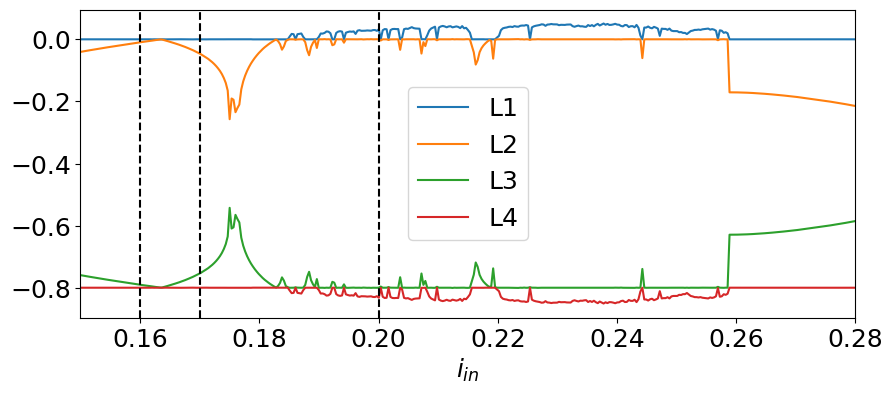

In [77]:
fig,ax=plt.subplots(1,1,figsize=(10,4))

for i in 1:4
  ax.plot(all_i_in_zoom,all_lyap_zoom[:,i],label="L"*string(i))
end
ax.axvline(x=0.16,c="k",ls="--")
ax.axvline(x=0.17,c="k",ls="--")
ax.axvline(x=0.20,c="k",ls="--")

ax.legend(loc="center")
#ax.set_ylabel(L"$L_i$")
ax.set_xlabel(L"$i_{in}$")
ax.set_xlim([all_i_in_zoom[1],all_i_in_zoom[end]])
plt.savefig("Spectrum_iin_zoom.png",bbox_inches="tight")

## LYAPUNOV SPECTRUM for $\Gamma \in [0.6,1]$ and $i_{in}=[0,0.4]$

In [38]:
L_p = 0.5
L_s =0.5
l = 0.1
h = 1.0
i_bi = 1.909

all_lyap = []
all_i_in_list = []
all_G_list = []

u0 = [0.0,0.0,0.0,0.0]

all_i_in = 0.0:(0.4)/100:0.4
all_G = 0.6:(1.0-0.6)/70:1.0

0.6:0.005714285714285714:1.0

In [229]:
@time begin
    all_lyap1 = Array{Float64}[]
    all_lyap2 = Array{Float64}[]
    all_i_in_list = Float64[]
    all_G_list= Float64[]
    params = Float64[-1,L_p, L_s, -1, l, h, i_bi]
    
    u0 = [0.0,0.0,0.0,0.0]
    u1 = [-1.0,0.0,-1.0,0.0]
    u2 = [0.0,20.0,0.0,0.0]
    
    ds = ContinuousDynamicalSystem(Josephson_neuron!, u0, params,Josephson_neuron_jacobian!)
    tinteg = tangent_integrator(ds,k=4;alg = Tsit5(),dtmax=0.5)
    
    for (index_i,i_in) in enumerate(all_i_in)
        
        if(mod(index_i,5)==0)
            println(i_in)
        end
        
        params[1] = i_in
        phip = find_phip_fp(params, 0.01)
        if(length(phip)!=0)
            phic = phic_in_fp(phip,params)
            u1[1] = phip[1]
            u1[3] = phic[1]
        end
        
        for (index_G,G) in enumerate(all_G)

            set_parameter!(ds,1,i_in)
            set_parameter!(ds,4,G)
            
            reinit!(tinteg, u1, orthonormal(4, 4))
            push!(all_lyap1,lyapunovspectrum(tinteg,2000.0,5.0,1000))
            
            reinit!(tinteg, u2, orthonormal(4, 4))
            push!(all_lyap2,lyapunovspectrum(tinteg,2000.0,5.0,1000))
            
            push!(all_i_in_list,i_in)
            push!(all_G_list,G)
            
        end
    end
end

0.016
0.036
0.056
0.076
0.096
0.116
0.136
0.156
0.176
0.196
0.216
0.236
0.256
0.276
0.296
0.316
0.336
0.356
0.376
0.396
35758.869286 seconds (87.82 G allocations: 3.812 TiB, 2.66% gc time)


In [39]:
if(false)
    save("lyapunovspectrum.jld", "spectrum1", all_lyap1, "spectrum2", all_lyap2)
else
    all_i_in_list = Float64[]
    all_G_list= Float64[]
    for (index_i,i_in) in enumerate(all_i_in)
        for (index_G,G) in enumerate(all_G)
            push!(all_i_in_list,i_in)
            push!(all_G_list,G)
            
        end
    end
    loader = load("lyapunovspectrum.jld")
    all_lyap1 = loader["spectrum1"]
    all_lyap2 = loader["spectrum2"]
end

spectrum1 = vcat(map(x->x', all_lyap1)...);
spectrum2 = vcat(map(x->x', all_lyap2)...);

areas1 = all_spectrum_to_values(spectrum1,0.005)
areas2 = all_spectrum_to_values(spectrum2,0.005);

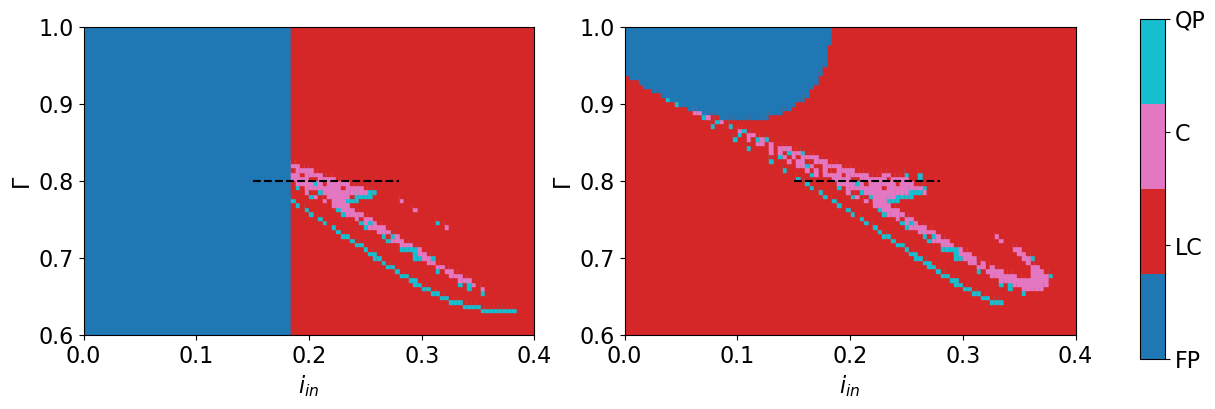

In [56]:
fig,axs=plt.subplots(1,2,figsize = (12.8,4))

cmap = plt.get_cmap("tab10", length(unique(areas2)))

#axs[1].set_title("Near fixed point")
axs[1].scatter(all_i_in_list,all_G_list,c=areas1,cmap=cmap,vmin=1,vmax=length(unique(areas2)),marker="s",s=34)
#axs[2].set_title("Near Limit cycle")
scat=axs[2].scatter(all_i_in_list,all_G_list,c=areas2,cmap=cmap,vmin=1,vmax=length(unique(areas2)),marker="s",s=34)

for i in [1,2]
    axs[i].set_xlabel(L"i_{in}")
    axs[i].set_ylabel("Γ")
    axs[i].set_ylim([all_G_list[1],all_G_list[end]])
    axs[i].set_xlim([all_i_in_list[1],all_i_in_list[end]])
    axs[i].plot([0.15,0.28],[0.8,0.8],c="k",ls="--")
end

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.05, 0.02, 0.85])

cbar = fig.colorbar(scat, cax=cbar_ax,cmap=cmap)
cbar.set_ticks([1,2,3,4,5])
cbar.set_ticklabels(["FP", "LC", "C","QP","OTHER"])

plt.show()

## Noise induced spiking

In [59]:
params = [0.182,0.5, 0.5, 0.95, 0.1, 1.0, 1.909,0.06]
u0= [0.0,0.0,0.0,0.0]
system = ODEProblem(Josephson_neuron_noise!, [0.0,0.0,0.0,0.0], [0.0,4200.0],params)
sol = solve(system,Tsit5(),adaptive=false,dt=0.01);

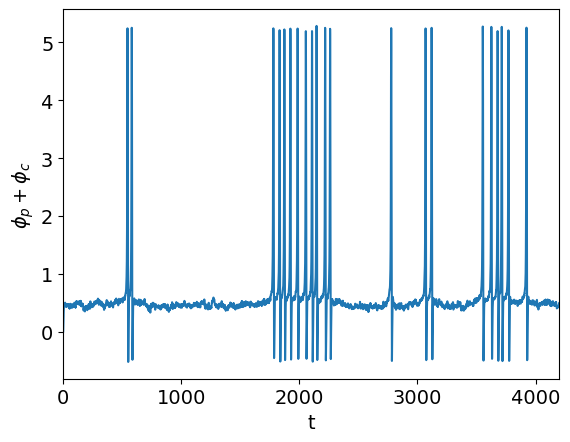

In [61]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 14

fig,axs=plt.subplots(1,1)
axs.plot(sol.t,sol[1,:]+sol[3,:])
axs.set_xlabel("t")
axs.set_xlim([0.0,4200.0])
axs.set_ylabel(L"\phi_p + \phi_c")
plt.savefig("noise_induced.png",bbox_inches="tight")

## SNL Bifurcation for $i_{in}$ and $\Gamma$ 

In [182]:
L_p = 0.5
L_s = 0.5
G   = 0.9
l   = 0.1
h   = 1.0
i_bi= 1.909

#Simulation time
time_sim = [0.0,1000.0]
max_step = 0.5

i_start = 0.11
i_end = 0.19
N = 600
#

all_i_in = range(i_end, i_start , length=N)
all_G_hom = range(0.882,0.99,length = 60)


i_hom = []


for (index_G,G) in enumerate(all_G_hom)
    index_G%5==0 ? println(G) : nothing
    y0 = [0.0,0.0,0.0,0.0]
    all_freq_info = []
    
    for (index,i_in) in enumerate(all_i_in)

        params = [i_in,L_p, L_s, G, l, h, i_bi]
        system = ODEProblem(Josephson_neuron_rotated!, y0, time_sim,params)
        sol = solve(system,Tsit5(),dtmax=max_step);
        y0 = sol[:,end]
        #Delete transient
        t = sol.t[Int(time_sim[2]/max_step/5):end]
        theta_1 = sol[1,Int(time_sim[2]/max_step/5):end]
        #Keep frequency maximum.
        push!(all_freq_info,find_frequency_error(theta_1,t))
    end

    all_freq_info = permutedims(reshape(hcat(all_freq_info...), (length(all_freq_info[1]), length(all_freq_info))));

    ind = all_freq_info[:,1].> 0.0
    push!(i_hom,all_i_in[ind][end])
end

0.8893220338983051
0.8984745762711864
0.9076271186440678
0.9167796610169492
0.9259322033898305
0.9350847457627118
0.9442372881355933
0.9533898305084746
0.9625423728813559
0.9716949152542372
0.9808474576271187
0.99


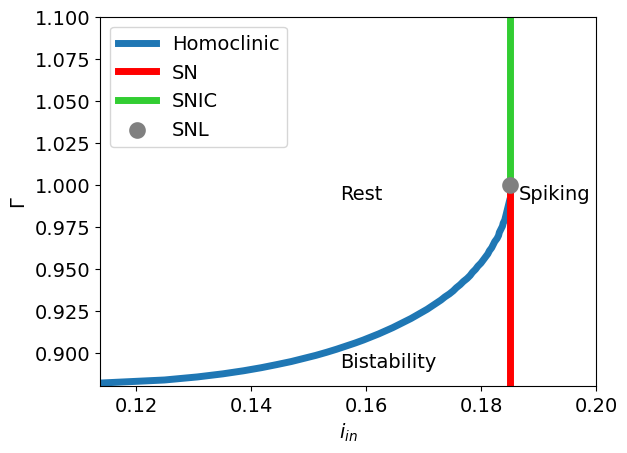

In [187]:
fig, ax = plt.subplots()
#ax.set_title("Codimension 2 Bifurcation diagram")
ax.plot(i_hom,all_G_hom,label="Homoclinic",lw=5)

G_end =1.1
G_start =0.88

ax.plot([0.185,0.185],[G_start,1],c="r",label="SN",lw=5)
ax.plot([0.185,0.185],[1,G_end],c="limegreen",label="SNIC",lw=5)
ax.scatter([0.185],[1],c="grey",label="SNL",zorder=10,lw=6)

ax.text(0.78,0.5,"Spiking",transform=fig.transFigure)
ax.text(0.5,0.15,"Bistability",transform=fig.transFigure)
ax.text(0.5,0.5,"Rest",transform=fig.transFigure)

ax.set_xlim([i_hom[1],0.2])
ax.set_ylim([G_start,G_end])
ax.set_xlabel(L"$i_{in}$")
ax.set_ylabel(L"$\Gamma$")
plt.legend()
plt.savefig("Cod2_Bif.png",bbox_inches="tight")